## NLP to Predict Disaster Tweets

This project uses NLP to clean ~10000 tweets and encode it using various vectorizers such as Count/Tf-Idf & Hashing. The encoded matrix is used to predict if the tweet is about a disaster, using multiple classifiers. A ridge regression classifier is taken as a benchmark, resulting is ~80% accuracy. Naive Bayes classifier, one of the most popular algorithms used in NLP was also implemented with hyper-parameter tuning, resulting in enhanced accuracies in both the K-folds validation set & out-of-sample test set.

#### Loading & Pre-processing (Dropping/ Missing value treatment)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [109]:
tweets_train = pd.read_csv("train.csv")
tweets_train = tweets_train.drop(columns = 'id')
tweets_train.head()

,keyword,location,text,target
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [110]:
tweets_train.shape[0]
tweets_train.isnull().sum()

keyword       61
location    2533
text           0
target         0
dtype: int64

In [111]:
print('The median of the location is', tweets_train.location.value_counts().index[0])
print('The median of the keyword is', tweets_train.keyword.value_counts().index[0])

The median of the location is USA
The median of the keyword is fatalities


In [112]:
tweets_train['location'] = np.where(tweets_train['location'].isna(), 'USA', tweets_train['location'])
tweets_train['keyword'] = np.where(tweets_train['keyword'].isna(), 'fatalities', tweets_train['keyword'])

In [7]:
tweets_train.isnull().sum()

keyword     0
location    0
text        0
target      0
dtype: int64

In [113]:
tweets_test = pd.read_csv("test.csv")
tweets_test = tweets_test.drop(columns = 'id')
tweets_test['location'] = np.where(tweets_test['location'].isna(), 'USA', tweets_test['location'])
tweets_test['keyword'] = np.where(tweets_test['keyword'].isna(), 'fatalities', tweets_test['keyword'])
tweets_train.isnull().sum()

keyword     0
location    0
text        0
target      0
dtype: int64

#### Tweet cleaning using string methods & NLTK 

In [228]:
# Defining a function that takes in the text & keyword of the tweet to return a cleaned text which can input into vectorizer 
import string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.corpus import stopwords
import re

punctuations_removal = str.maketrans('','', string.punctuation) # creating a mapping to remove punctuations
stops = stopwords.words('english') # creating a list of stop words in English

def clean_tweets(input_text, keyword):
    
    if type(input_text) == float:
        return ""
    punctuations_removal = str.maketrans('','', string.punctuation) # creating a mapping to remove punctuations
    stops = stopwords.words('english') # creating a list of stop words in English
    temp = input_text.lower() # converting to lowercase
    temp = temp = re.sub(r'http\S+', '', temp) #removing links
    keyword = str(keyword) # converting pandas to string
    
    tokens = word_tokenize(temp) # converting strings to list of word
    stripped_tokens = [words.translate(punctuations_removal) for words in tokens] # removing punctuations
    stripped_tokens = stripped_tokens + [keyword] # adding keyword to the list
    stripped_tokens = [word for word in stripped_tokens if word.isalpha()]# removing non-alphanumeric words 
    stripped_tokens = [lemmatizer.lemmatize(word) for word in stripped_tokens] # lemmatizing
    stripped_tokens = [word for word in stripped_tokens if word not in stops] # removing stop words  
    return ' '.join(stripped_tokens) # joining words to a text list

In [226]:
# cleaning tweets taggeed as disasters to plot words with most frequencies
disaster_tweets = tweets_train.loc[tweets_train['target'] == 1,]
disaster_tweets['final_text'] = disaster_tweets.apply(lambda x: clean_tweets(x['text'], ' '), axis = 1)
word_corpus = []
disaster_tweets.head()
for i in range(0, disaster_tweets.shape[0]):
    words = disaster_tweets.iloc[i,4].split()
    for word in words:
        word_corpus.append(word)

<ipython-input-226-9ae5f1bab1ea>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  disaster_tweets['final_text'] = disaster_tweets.apply(lambda x: clean_tweets(x['text'], ' '), axis = 1)


Text(0.5, 0, 'Frequency')

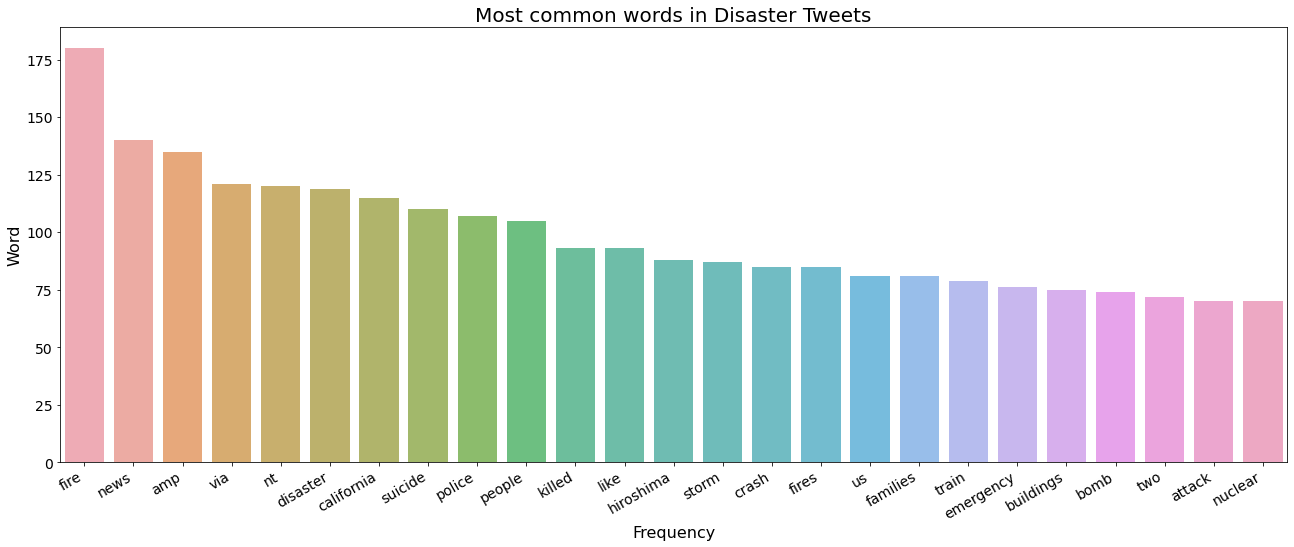

In [227]:
from collections import Counter
high_frequencies = pd.DataFrame(Counter(word_corpus).most_common(25), columns=['word', 'count'])

fig, ax = plt.subplots(figsize = (22,8))
ax = sns.barplot(data = high_frequencies, x = 'word', y = 'count', alpha = 0.8)
plt.xticks(ha = 'right', fontsize = 14, rotation = 30)
plt.yticks(fontsize = 14)
ax.set_title('Most common words in Disaster Tweets', fontsize = 20)
ax.set_ylabel('Word', fontsize = 16)
ax.set_xlabel('Frequency', fontsize = 16)

In [181]:
# applying the cleaner function on the dataset
tweets_train['final_text'] = tweets_train.apply(lambda x: clean_tweets(x['text'], x['keyword']), axis = 1)

In [184]:
# Splitting dataset into train & test sets
from sklearn.model_selection import train_test_split
X = tweets_train['final_text']
y = tweets_train['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

### Vectorizer functions to encode cleaned texts

We will use three encoder systems to convert the cleaned texts into numerical inputs for the classifer. A baseline model (Ridge-Classifier) is used to compare the efficiences of the encoders.

#### Count vectorizer
This encoder creates a vocubulary based on the text corpus & encodes each tweet into a sparse matrix containing the frequency occurences of each word in the tweet

In [185]:
# creating the count vectorizer function
vectorizer = feature_extraction.text.CountVectorizer()
# creating a vocabulary based on X-train texts
vectorizer.fit(X_train)
# fitting it on the train & test datasets
tweets_train_vectors = vectorizer.transform(X_train)
tweets_test_vectors = vectorizer.transform(X_test)

In [186]:
print(X_train[0])
print(tweets_train_vectors[0].toarray())

deed reason earthquake may allah forgive u fatality
[[0 0 0 ... 0 0 0]]


In [187]:
print(tweets_train_vectors[0].todense().shape)

(1, 12301)


In [188]:
# Fitting final features in the training data & reporting K-folds validation scores
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import metrics
from numpy import mean
from numpy import std

clf = RidgeClassifier()
clf.fit(tweets_train_vectors, y_train)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
scores = cross_val_score(clf, tweets_train_vectors, y_train, cv=cv, scoring="accuracy", n_jobs = -1)
print('Accuracy on K-folds validation on train set: %.3f (%.3f)' % (mean(scores), std(scores)))
print('Accuracy of Ridge regression classifier on test set: {:.2f}'.format(clf.score(tweets_test_vectors, y_test)))

Accuracy on K-folds validation on train set: 0.771 (0.017)
Accuracy of Ridge regression classifier on test set: 0.78


#### Term Frequency - Inverse Document Frequency Vectorizer

To penalize the occurence of commonly used terms, the Tf-Idf vectorizer calculates word frequencies in a tweet & downsizes it based on the number of tweets containing the same word in the entire document corpus

In [189]:
# creating the Tf-IDF vectorizer function
vectorizer = feature_extraction.text.TfidfVectorizer()
# creating a vocabulary based on X-train texts
vectorizer.fit(X_train)
# fitting it on the train & test datasets
tweets_train_vectors = vectorizer.transform(X_train)

In [190]:
# Fitting final features in the training data & reporting K-folds validation scores
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import metrics
from numpy import mean
from numpy import std

clf = RidgeClassifier()
clf.fit(tweets_train_vectors, y_train)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
scores = cross_val_score(clf, tweets_train_vectors, y_train, cv=cv, scoring="accuracy", n_jobs = -1)
print('Accuracy on K-folds validation on train set: %.3f (%.3f)' % (mean(scores), std(scores)))
print('Accuracy of Ridge regression classifier on test set: {:.2f}'.format(clf.score(tweets_test_vectors, y_test)))

Accuracy on K-folds validation on train set: 0.792 (0.015)
Accuracy of Ridge regression classifier on test set: 0.80


### Naive Bayes Classifier

In a small dataset such as ours, Naive Bayes might work well since it assumes that the words in the tweet are now independent of each other & we can use the probabilities of each word in the entire corpus to determine the conditional probability of a tweet being about a disaster.  
For words that never appear in the corpus, NB uses Laplace smoother (adding 1 to the frequency of each term & adding n (unique words) to the denominator) to avoid probability to plummet to zero.  

In [191]:
# Fitting final features in the training data & reporting K-folds validation scores
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import metrics
from numpy import mean
from numpy import std

clf = MultinomialNB()
clf.fit(tweets_train_vectors, y_train)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
scores = cross_val_score(clf, tweets_train_vectors, y_train, cv=cv, scoring="accuracy", n_jobs = -1)
print('Accuracy on K-folds validation on train set: %.3f (%.3f)' % (mean(scores), std(scores)))
print('Accuracy of Naive Bayes classifier on test set: {:.2f}'.format(clf.score(tweets_test_vectors, y_test)))

Accuracy on K-folds validation on train set: 0.797 (0.016)
Accuracy of Naive Bayes classifier on test set: 0.80


#### Fitting the data into the testset & submitting results to Kaggle

The test dataset does not contain the target class, so we will fit the Naive Bayes model to the test set & submit the predictions. 

In [195]:
# applying the cleaner function on the dataset
tweets_test['final_text'] = tweets_test.apply(lambda x: clean_tweets(x['text'], x['keyword']), axis = 1)
outsample_X = tweets_test['final_text']
outsample_vectors = vectorizer.transform(outsample_X)
tweets_test['target'] = clf.predict(outsample_vectors)

In this project, we used NLTK & string methods to clean tweets. The cleaned tweets were vectorized & tested with two models : Ridge & Naive Bayes classifier.  
Owing to the small size & content constraints, the NB classifier worked out slightly better than the baseline model. We can explore more sophisticated methods such as SVM, Neural Networks etc to improve performance. 